In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
from typing import Tuple, Optional
import torch.utils.checkpoint as checkpoint
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
# from sklearn.metrics import confusion_matrix, classification_report,f1_score,accuracy_score
from tqdm import tqdm, trange
import seaborn as sns
import gc
import time
import pywt
import math
from collections import deque
import psutil
import os
from scipy import signal
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

In [2]:
# File paths
FILE_PATH = "C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\GOLD_XYZ_OSC.0001_1024.hdf5"
JSON_PATH = 'C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\classes-fixed.json' 

# Focused experiment setup
TARGET_MODULATIONS = ['8PSK', '16QAM', '32QAM']  # 3 modulations (fixed comment)
TARGET_SNRS = [-6, 6, 18]  # Low, Medium, High SNR

# IMPORTANT: Set NUM_CLASSES correctly!
NUM_CLASSES = len(TARGET_MODULATIONS)  # This should be 3, not 2!

# Processing options
FEATURE_METHOD = 'statistical' 
OUTPUT_DIR = 'Dataset_Wavelet/focused_experiment_1d_statistical'  # Output directory for focused experiment
TRAIN_RATIO = 0.75
VALID_RATIO = 0.25

# Feature extraction settings
TARGET_LENGTH = 1024 
NUM_FFT_BINS = 256
NUM_WAVELET_LEVELS = 6

print(f"🎯 Focused 1D Experiment Setup:")
print(f"   Modulations: {TARGET_MODULATIONS}")
print(f"   Number of classes: {NUM_CLASSES}")  # Add this line
print(f"   SNR levels: {TARGET_SNRS}")
print(f"   Feature method: {FEATURE_METHOD}")
print(f"   Target length: {TARGET_LENGTH}")
print(f"   Output directory: {OUTPUT_DIR}")

# Verify the setup
assert NUM_CLASSES == len(TARGET_MODULATIONS), f"NUM_CLASSES ({NUM_CLASSES}) must equal len(TARGET_MODULATIONS) ({len(TARGET_MODULATIONS)})"
print(f"✅ Configuration validated: {NUM_CLASSES} classes for {TARGET_MODULATIONS}")

🎯 Focused 1D Experiment Setup:
   Modulations: ['8PSK', '16QAM', '32QAM']
   Number of classes: 3
   SNR levels: [-6, 6, 18]
   Feature method: statistical
   Target length: 1024
   Output directory: Dataset_Wavelet/focused_experiment_1d_statistical
✅ Configuration validated: 3 classes for ['8PSK', '16QAM', '32QAM']


In [3]:
def load_and_filter_data_debug():
    """Load RadioML data and filter for target modulations and SNRs with extensive debugging."""
    
    print("📂 Loading and filtering RadioML data with debugging...")
    
    # Load files
    h5_file = h5py.File(FILE_PATH, 'r')
    with open(JSON_PATH, 'r') as f:
        modulation_classes = json.load(f)
    
    # Load arrays
    X = h5_file['X']  # Shape: (samples, 1024, 2)
    Y = np.argmax(h5_file['Y'], axis=1)  # Labels
    Z = h5_file['Z'][:, 0]  # SNRs
    
    print(f"   Original dataset: {X.shape[0]} samples")
    print(f"   Shape - X: {X.shape}, Y: {Y.shape}, Z: {Z.shape}")
    
    # ==================== DETAILED DEBUGGING ====================
    print(f"\n🔍 MODULATION CLASSES ANALYSIS:")
    print(f"   Total modulations in JSON: {len(modulation_classes)}")
    print(f"   All modulations: {modulation_classes}")
    
    print(f"\n🎯 TARGET MODULATION ANALYSIS:")
    print(f"   TARGET_MODULATIONS: {TARGET_MODULATIONS}")
    
    # Check if target modulations exist in the dataset
    missing_mods = []
    target_mod_indices = []
    for mod in TARGET_MODULATIONS:
        if mod in modulation_classes:
            idx = modulation_classes.index(mod)
            target_mod_indices.append(idx)
            print(f"   ✅ {mod} found at index {idx}")
        else:
            missing_mods.append(mod)
            print(f"   ❌ {mod} NOT FOUND in modulation classes!")
    
    if missing_mods:
        print(f"\n⚠️  MISSING MODULATIONS: {missing_mods}")
        print(f"   Available similar modulations:")
        for mod in modulation_classes:
            if any(missing in mod.upper() for missing in [m.upper() for m in missing_mods]):
                print(f"     - {mod}")
        return None, None, None, None
    
    print(f"   Target modulation indices: {dict(zip(TARGET_MODULATIONS, target_mod_indices))}")
    
    # ==================== SNR ANALYSIS ====================
    print(f"\n📡 SNR ANALYSIS:")
    unique_snrs = np.unique(Z)
    print(f"   Available SNRs in dataset: {sorted(unique_snrs)}")
    print(f"   TARGET_SNRS: {TARGET_SNRS}")
    
    missing_snrs = [snr for snr in TARGET_SNRS if snr not in unique_snrs]
    if missing_snrs:
        print(f"   ⚠️  Missing SNRs: {missing_snrs}")
    
    # ==================== ORIGINAL LABEL DISTRIBUTION ====================
    print(f"\n📊 ORIGINAL LABEL DISTRIBUTION:")
    unique_labels = np.unique(Y)
    print(f"   Unique labels in dataset: {unique_labels}")
    
    for label in unique_labels:
        count = np.sum(Y == label)
        if label < len(modulation_classes):
            mod_name = modulation_classes[label]
        else:
            mod_name = f"Unknown_{label}"
        print(f"   Label {label} ({mod_name}): {count} samples")
    
    # ==================== DETAILED FILTERING ANALYSIS ====================
    print(f"\n🔍 DETAILED FILTERING ANALYSIS:")
    
    mask = np.zeros(len(Y), dtype=bool)
    total_found = 0
    
    for i, mod_idx in enumerate(target_mod_indices):
        mod_name = TARGET_MODULATIONS[i]
        mod_total = 0
        
        print(f"\n   Analyzing {mod_name} (original label {mod_idx}):")
        
        # Check if this modulation exists at all
        mod_exists = np.sum(Y == mod_idx)
        print(f"     - Total samples in dataset: {mod_exists}")
        
        if mod_exists == 0:
            print(f"     ❌ {mod_name} has 0 samples in the entire dataset!")
            continue
        
        # Check at each SNR level
        for snr in TARGET_SNRS:
            condition = (Y == mod_idx) & (Z == snr)
            count = np.sum(condition)
            mask |= condition
            mod_total += count
            total_found += count
            
            if count > 0:
                print(f"     ✅ at {snr}dB: {count} samples")
            else:
                print(f"     ❌ at {snr}dB: {count} samples")
                
                # Check what SNRs are available for this modulation
                available_snrs = np.unique(Z[Y == mod_idx])
                print(f"        Available SNRs for {mod_name}: {sorted(available_snrs)}")
        
        print(f"     Total for {mod_name}: {mod_total} samples")
    
    print(f"\n📈 FILTERING SUMMARY:")
    print(f"   Total samples found: {total_found}")
    
    if total_found == 0:
        print(f"   ❌ No samples found! Check modulation names or SNR values.")
        h5_file.close()
        return None, None, None, None
    
    # Apply filter
    X_filtered = X[mask]
    Y_filtered = Y[mask].copy()
    Z_filtered = Z[mask]
    
    # ==================== LABEL REMAPPING ====================
    print(f"\n🏷️  LABEL REMAPPING:")
    
    label_mapping = {}
    Y_remapped = np.zeros_like(Y_filtered)
    
    for new_label, old_label in enumerate(target_mod_indices):
        old_mask = Y_filtered == old_label
        Y_remapped[old_mask] = new_label
        label_mapping[old_label] = new_label
        count = np.sum(old_mask)
        
        if count > 0:
            print(f"   ✅ Remapped {TARGET_MODULATIONS[new_label]} ({old_label} -> {new_label}): {count} samples")
        else:
            print(f"   ⚠️  Remapped {TARGET_MODULATIONS[new_label]} ({old_label} -> {new_label}): {count} samples (MISSING!)")
    
    # Final verification
    unique_new_labels = np.unique(Y_remapped)
    print(f"\n✅ FINAL RESULTS:")
    print(f"   Filtered dataset: {X_filtered.shape[0]} samples")
    print(f"   Final labels in data: {unique_new_labels}")
    print(f"   Expected labels: {list(range(len(TARGET_MODULATIONS)))}")
    print(f"   Label mapping: {label_mapping}")
    
    # Check for missing labels
    expected_labels = set(range(len(TARGET_MODULATIONS)))
    actual_labels = set(unique_new_labels)
    missing_labels = expected_labels - actual_labels
    
    if missing_labels:
        print(f"   ❌ Missing labels: {missing_labels}")
        for missing_label in missing_labels:
            print(f"      - Label {missing_label} corresponds to {TARGET_MODULATIONS[missing_label]}")
    else:
        print(f"   ✅ All expected labels found!")
    
    h5_file.close()
    return X_filtered, Y_remapped, Z_filtered, label_mapping

# Call the debug function
X_filtered, Y_remapped, Z_filtered, label_mapping = load_and_filter_data_debug()

📂 Loading and filtering RadioML data with debugging...
   Original dataset: 2555904 samples
   Shape - X: (2555904, 1024, 2), Y: (2555904,), Z: (2555904,)

🔍 MODULATION CLASSES ANALYSIS:
   Total modulations in JSON: 24
   All modulations: ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']

🎯 TARGET MODULATION ANALYSIS:
   TARGET_MODULATIONS: ['8PSK', '16QAM', '32QAM']
   ✅ 8PSK found at index 5
   ✅ 16QAM found at index 12
   ✅ 32QAM found at index 13
   Target modulation indices: {'8PSK': 5, '16QAM': 12, '32QAM': 13}

📡 SNR ANALYSIS:
   Available SNRs in dataset: [np.int64(-20), np.int64(-18), np.int64(-16), np.int64(-14), np.int64(-12), np.int64(-10), np.int64(-8), np.int64(-6), np.int64(-4), np.int64(-2), np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(10), np.int64(12), np.int64(1

In [4]:
def extract_amplitude_phase_features(i_signal, q_signal):
    """Extract amplitude and phase as 1D time series."""
    
    # Calculate amplitude and phase
    amplitude = np.sqrt(i_signal**2 + q_signal**2)
    phase = np.arctan2(q_signal, i_signal)
    
    # Unwrap phase to avoid discontinuities
    phase_unwrapped = np.unwrap(phase)
    
    # Resize to target length
    amplitude_resized = resize_to_target_length(amplitude)
    phase_resized = resize_to_target_length(phase_unwrapped)
    
    return amplitude_resized.astype(np.float32), phase_resized.astype(np.float32)

def extract_iq_raw_features(i_signal, q_signal):
    """Simple I/Q channel features (minimal processing)."""
    
    # Just resize the raw I/Q signals
    i_resized = resize_to_target_length(i_signal)
    q_resized = resize_to_target_length(q_signal)
    
    return i_resized.astype(np.float32), q_resized.astype(np.float32)

def extract_fft_features(i_signal, q_signal):
    """Extract FFT magnitude and phase as 1D features."""
    
    # Combine I/Q into complex signal
    complex_signal = i_signal + 1j * q_signal
    
    # Compute FFT
    fft_result = fft(complex_signal)
    
    # Extract magnitude and phase
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    
    # Take only the first half (positive frequencies)
    half_length = len(magnitude) // 2
    magnitude = magnitude[:half_length]
    phase = phase[:half_length]
    
    # Resize to target length
    magnitude_resized = resize_to_target_length(magnitude)
    phase_resized = resize_to_target_length(phase)
    
    return magnitude_resized.astype(np.float32), phase_resized.astype(np.float32)

def extract_wavelet_coeffs(i_signal, q_signal):
    """Extract 1D wavelet coefficients."""
    
    # Apply DWT to I and Q channels
    wavelet = 'db4'
    
    # Multi-level wavelet decomposition
    coeffs_i = pywt.wavedec(i_signal, wavelet, level=NUM_WAVELET_LEVELS)
    coeffs_q = pywt.wavedec(q_signal, wavelet, level=NUM_WAVELET_LEVELS)
    
    # Concatenate all coefficients into 1D arrays
    i_features = np.concatenate(coeffs_i)
    q_features = np.concatenate(coeffs_q)
    
    # Resize to target length
    i_resized = resize_to_target_length(i_features)
    q_resized = resize_to_target_length(q_features)
    
    return i_resized.astype(np.float32), q_resized.astype(np.float32)

def extract_statistical_features(i_signal, q_signal):
    """Extract statistical features using sliding windows."""
    
    # Window size for statistical calculations
    window_size = 64
    hop_size = 32
    
    # Calculate sliding window statistics
    i_stats = []
    q_stats = []
    
    for start in range(0, len(i_signal) - window_size + 1, hop_size):
        end = start + window_size
        
        i_window = i_signal[start:end]
        q_window = q_signal[start:end]
        
        # Statistical features for each window
        i_stats.extend([
            np.mean(i_window), np.std(i_window), 
            np.var(i_window), np.max(i_window), np.min(i_window),
            np.median(i_window), np.ptp(i_window)  # peak-to-peak
        ])
        
        q_stats.extend([
            np.mean(q_window), np.std(q_window),
            np.var(q_window), np.max(q_window), np.min(q_window),
            np.median(q_window), np.ptp(q_window)
        ])
    
    i_stats = np.array(i_stats)
    q_stats = np.array(q_stats)
    
    # Resize to target length
    i_resized = resize_to_target_length(i_stats)
    q_resized = resize_to_target_length(q_stats)
    
    return i_resized.astype(np.float32), q_resized.astype(np.float32)

def safe_decode_attr(attr):
    """Safely decode HDF5 attribute (handles both string and bytes)."""
    if isinstance(attr, bytes):
        return attr.decode('utf-8')
    return str(attr)

def resize_to_target_length(signal_1d):
    """Resize 1D signal to target length using interpolation."""
    
    current_length = len(signal_1d)
    
    if current_length == TARGET_LENGTH:
        return signal_1d
    
    # Create interpolation indices
    old_indices = np.linspace(0, current_length - 1, current_length)
    new_indices = np.linspace(0, current_length - 1, TARGET_LENGTH)
    
    # Interpolate
    resized = np.interp(new_indices, old_indices, signal_1d)
    
    return resized

In [7]:
def preprocess_focused_dataset():
    """Main preprocessing pipeline for focused 1D experiment."""
    
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Load and filter data
    X_filtered, Y_filtered, Z_filtered, label_mapping = load_and_filter_data_debug()
    
    total_samples = len(X_filtered)
    print(f"\n🌊 Processing {total_samples} samples with {FEATURE_METHOD} method...")
    
    # Select feature extraction method
    if FEATURE_METHOD == 'amplitude_phase':
        extract_features = extract_amplitude_phase_features
        feature_names = ['amplitude', 'phase']
    elif FEATURE_METHOD == 'iq_raw':
        extract_features = extract_iq_raw_features
        feature_names = ['i_channel', 'q_channel']
    elif FEATURE_METHOD == 'fft_features':
        extract_features = extract_fft_features
        feature_names = ['fft_magnitude', 'fft_phase']
    elif FEATURE_METHOD == 'wavelet_coeffs':
        extract_features = extract_wavelet_coeffs
        feature_names = ['i_wavelets', 'q_wavelets']
    elif FEATURE_METHOD == 'statistical':
        extract_features = extract_statistical_features
        feature_names = ['i_statistics', 'q_statistics']
    else:
        raise ValueError(f"Unknown feature method: {FEATURE_METHOD}")
    
    # Process all samples
    start_time = time.time()
    
    feature1_list = []
    feature2_list = []
    labels_list = []
    snrs_list = []
    
    for i in tqdm(range(total_samples), desc="Processing samples"):
        # Extract I/Q signals
        i_signal = X_filtered[i, :, 0]
        q_signal = X_filtered[i, :, 1]
        
        # Apply feature extraction
        feature1, feature2 = extract_features(i_signal, q_signal)
        
        # Store results
        feature1_list.append(feature1)
        feature2_list.append(feature2)
        labels_list.append(Y_filtered[i])
        snrs_list.append(Z_filtered[i])
    
    # Convert to numpy arrays
    features1 = np.array(feature1_list)
    features2 = np.array(feature2_list)
    labels = np.array(labels_list)
    snrs = np.array(snrs_list)
    
    processing_time = time.time() - start_time
    print(f"✅ Processing complete in {processing_time/60:.1f} minutes")
    print(f"   Features shape: {features1.shape}, {features2.shape}")
    print(f"   Speed: {total_samples/processing_time:.1f} samples/second")
    
    # Create train/valid splits
    create_train_valid_splits(features1, features2, labels, snrs, feature_names)
    
    return features1, features2, labels, snrs

def create_train_valid_splits(features1, features2, labels, snrs, feature_names):
    """Create train/validation splits and save to HDF5."""
    
    print(f"\n📊 Creating train/validation splits...")
    
    # Stratified split to maintain modulation/SNR balance
    train_indices = []
    valid_indices = []
    
    # FIX: Use actual number of classes instead of hardcoded [0, 1]
    for mod_label in range(NUM_CLASSES):  # This will be [0, 1, 2] for 3 classes
        for snr in TARGET_SNRS:
            # Find samples for this combination
            mask = (labels == mod_label) & (snrs == snr)
            indices = np.where(mask)[0]
            
            if len(indices) == 0:
                print(f"   ⚠️  Warning: No samples found for label {mod_label} at {snr}dB")
                continue
            
            # Shuffle and split
            np.random.shuffle(indices)
            split_point = int(TRAIN_RATIO * len(indices))
            
            train_indices.extend(indices[:split_point])
            valid_indices.extend(indices[split_point:])
            
            mod_name = TARGET_MODULATIONS[mod_label]
            print(f"   {mod_name} at {snr}dB: {len(indices)} total, {split_point} train, {len(indices)-split_point} valid")
    
    train_indices = np.array(train_indices)
    valid_indices = np.array(valid_indices)
    
    print(f"   Train samples: {len(train_indices)}")
    print(f"   Valid samples: {len(valid_indices)}")
    
    # Save train split
    save_split('train', train_indices, features1, features2, labels, snrs, feature_names)
    
    # Save validation split
    save_split('valid', valid_indices, features1, features2, labels, snrs, feature_names)


def save_split(split_name, indices, features1, features2, labels, snrs, feature_names):
    """Save a data split to HDF5 file."""
    
    output_file = os.path.join(OUTPUT_DIR, f'{split_name}_{FEATURE_METHOD}.h5')
    
    with h5py.File(output_file, 'w') as f:
        # Save features
        f.create_dataset('feature1', data=features1[indices], compression='gzip')
        f.create_dataset('feature2', data=features2[indices], compression='gzip')
        f.create_dataset('labels', data=labels[indices])
        f.create_dataset('snrs', data=snrs[indices])
        
        # Save metadata
        f.attrs['num_samples'] = len(indices)
        f.attrs['feature_method'] = FEATURE_METHOD
        f.attrs['feature1_name'] = feature_names[0]
        f.attrs['feature2_name'] = feature_names[1]
        f.attrs['modulations'] = TARGET_MODULATIONS
        f.attrs['target_snrs'] = TARGET_SNRS
        f.attrs['num_classes'] = NUM_CLASSES  # FIX: Use variable instead of hardcoded 2
        f.attrs['feature_length'] = TARGET_LENGTH
        f.attrs['is_1d'] = True
    
    file_size = os.path.getsize(output_file) / (1024**2)  # MB
    print(f"   {split_name}: {output_file} ({file_size:.1f} MB)")

In [8]:
features1, features2, labels, snrs = preprocess_focused_dataset()

📂 Loading and filtering RadioML data with debugging...
   Original dataset: 2555904 samples
   Shape - X: (2555904, 1024, 2), Y: (2555904,), Z: (2555904,)

🔍 MODULATION CLASSES ANALYSIS:
   Total modulations in JSON: 24
   All modulations: ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM', '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK', 'OQPSK']

🎯 TARGET MODULATION ANALYSIS:
   TARGET_MODULATIONS: ['8PSK', '16QAM', '32QAM']
   ✅ 8PSK found at index 5
   ✅ 16QAM found at index 12
   ✅ 32QAM found at index 13
   Target modulation indices: {'8PSK': 5, '16QAM': 12, '32QAM': 13}

📡 SNR ANALYSIS:
   Available SNRs in dataset: [np.int64(-20), np.int64(-18), np.int64(-16), np.int64(-14), np.int64(-12), np.int64(-10), np.int64(-8), np.int64(-6), np.int64(-4), np.int64(-2), np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(10), np.int64(12), np.int64(1

Processing samples: 100%|██████████| 36864/36864 [01:42<00:00, 359.04it/s]


✅ Processing complete in 1.7 minutes
   Features shape: (36864, 1024), (36864, 1024)
   Speed: 358.8 samples/second

📊 Creating train/validation splits...
   8PSK at -6dB: 4096 total, 3072 train, 1024 valid
   8PSK at 6dB: 4096 total, 3072 train, 1024 valid
   8PSK at 18dB: 4096 total, 3072 train, 1024 valid
   16QAM at -6dB: 4096 total, 3072 train, 1024 valid
   16QAM at 6dB: 4096 total, 3072 train, 1024 valid
   16QAM at 18dB: 4096 total, 3072 train, 1024 valid
   32QAM at -6dB: 4096 total, 3072 train, 1024 valid
   32QAM at 6dB: 4096 total, 3072 train, 1024 valid
   32QAM at 18dB: 4096 total, 3072 train, 1024 valid
   Train samples: 27648
   Valid samples: 9216
   train: Dataset_Wavelet/focused_experiment_1d_statistical\train_statistical.h5 (198.7 MB)
   valid: Dataset_Wavelet/focused_experiment_1d_statistical\valid_statistical.h5 (66.3 MB)


In [9]:
def visualize_1d_samples():
    """Visualize sample 1D features to verify processing."""
    
    print(f"\n🔍 Visualizing sample 1D features...")
    
    # Load train data
    train_file = os.path.join(OUTPUT_DIR, f'train_{FEATURE_METHOD}.h5')
    
    with h5py.File(train_file, 'r') as f:
        features1 = f['feature1'][:6]  # First 6 samples
        features2 = f['feature2'][:6]
        labels = f['labels'][:6]
        snrs = f['snrs'][:6]
        
        # Handle string attributes safely
        feature1_name = safe_decode_attr(f.attrs['feature1_name'])
        feature2_name = safe_decode_attr(f.attrs['feature2_name'])
    
    # Plot samples
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle(f'Sample 1D Features: {FEATURE_METHOD}', fontsize=16)
    
    for i in range(6):
        row = i // 2
        col = i % 2
        
        # Plot both features for each sample
        x_axis = np.arange(len(features1[i]))
        
        axes[row, col].plot(x_axis, features1[i], label=feature1_name, alpha=0.8, linewidth=1)
        axes[row, col].plot(x_axis, features2[i], label=feature2_name, alpha=0.8, linewidth=1)
        
        mod_name = TARGET_MODULATIONS[labels[i]]
        axes[row, col].set_title(f'{mod_name} at {snrs[i]:.0f}dB')
        axes[row, col].set_xlabel('Sample Index')
        axes[row, col].set_ylabel('Amplitude')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'sample_1d_features_{FEATURE_METHOD}.png'), dpi=150)
    plt.show()
    
    print(f"✅ Sample 1D visualization saved")


🔍 Visualizing sample 1D features...


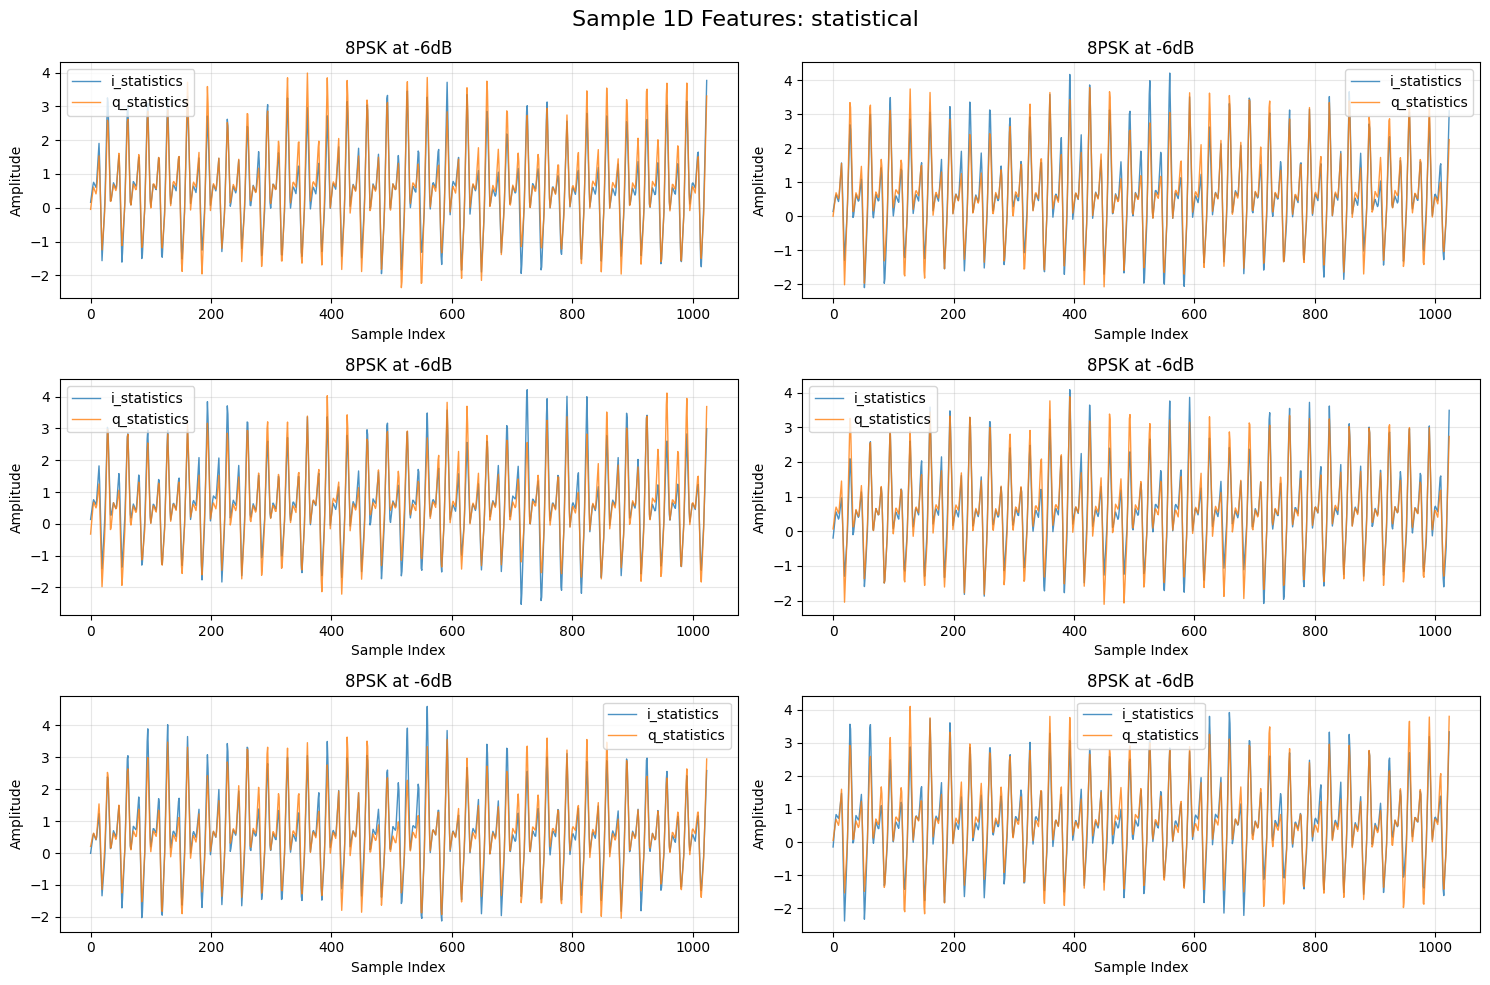

✅ Sample 1D visualization saved


In [10]:
visualize_1d_samples()

## Visualize The Modulation 


🔍 Starting visualization with debugging...
✅ Successfully loaded data from: Dataset_Wavelet/focused_experiment_1d_statistical\train_statistical.h5

📊 DATA ANALYSIS:
Features1 shape: (27648, 1024)
Features2 shape: (27648, 1024)
Labels shape: (27648,)
SNRs shape: (27648,)
Feature1 name: i_statistics
Feature2 name: q_statistics

🏷️  LABEL ANALYSIS:
Unique labels in data: [0 1 2]
Label distribution: {np.int64(0): np.int64(9216), np.int64(1): np.int64(9216), np.int64(2): np.int64(9216)}

📡 SNR ANALYSIS:
Unique SNRs in data: [-6  6 18]
TARGET_SNRS expected: [-6, 6, 18]

🎯 MODULATION MAPPING:
NUM_CLASSES: 3
TARGET_MODULATIONS: ['8PSK', '16QAM', '32QAM']
TARGET_MODULATIONS[:NUM_CLASSES]: ['8PSK', '16QAM', '32QAM']
Expected label mapping: {0: '8PSK', 1: '16QAM', 2: '32QAM'}

🔍 SAMPLE COUNT ANALYSIS:

Label 0 (8PSK): 9216 total samples
  - at -6dB: 3072 samples
  - at 6dB: 3072 samples
  - at 18dB: 3072 samples

Label 1 (16QAM): 9216 total samples
  - at -6dB: 3072 samples
  - at 6dB: 3072 samp

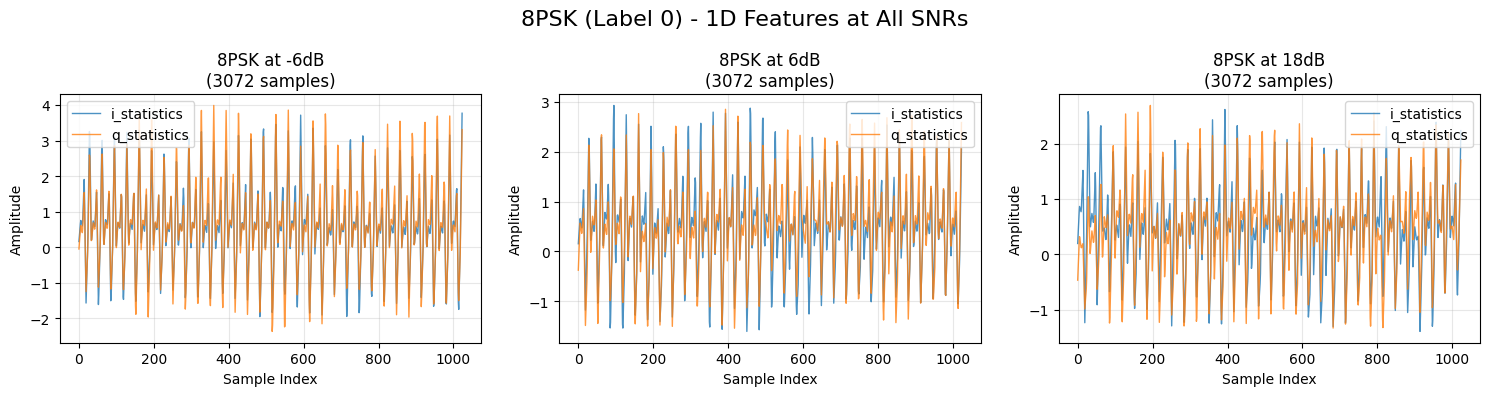

✅ Saved: sample_1d_8PSK_label0_statistical.png

📈 Processing 16QAM (label 1)...
  - 16QAM at -6dB: found 3072 samples
  - 16QAM at 6dB: found 3072 samples
  - 16QAM at 18dB: found 3072 samples


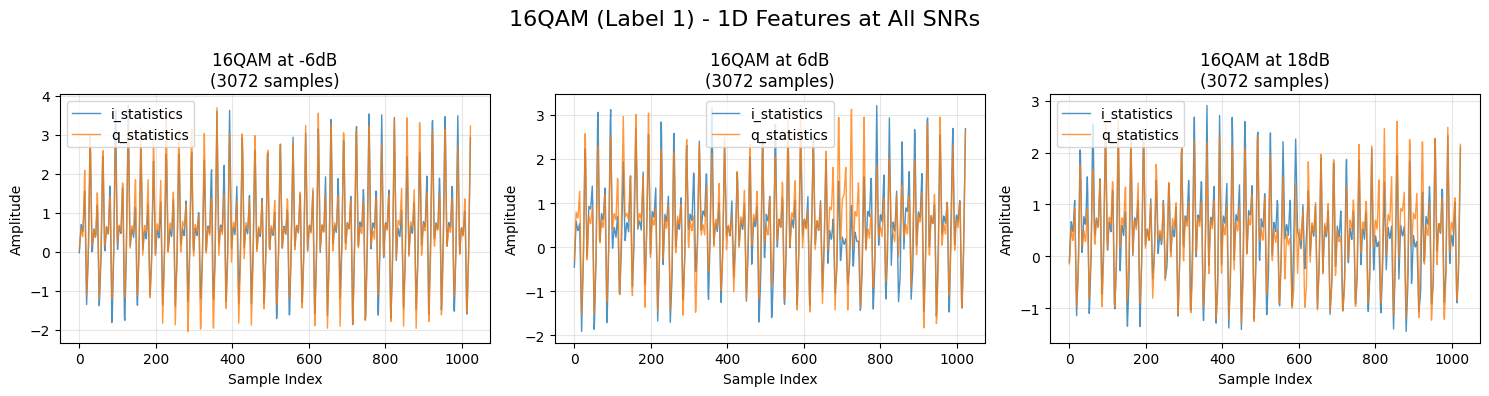

✅ Saved: sample_1d_16QAM_label1_statistical.png

📈 Processing 32QAM (label 2)...
  - 32QAM at -6dB: found 3072 samples
  - 32QAM at 6dB: found 3072 samples
  - 32QAM at 18dB: found 3072 samples


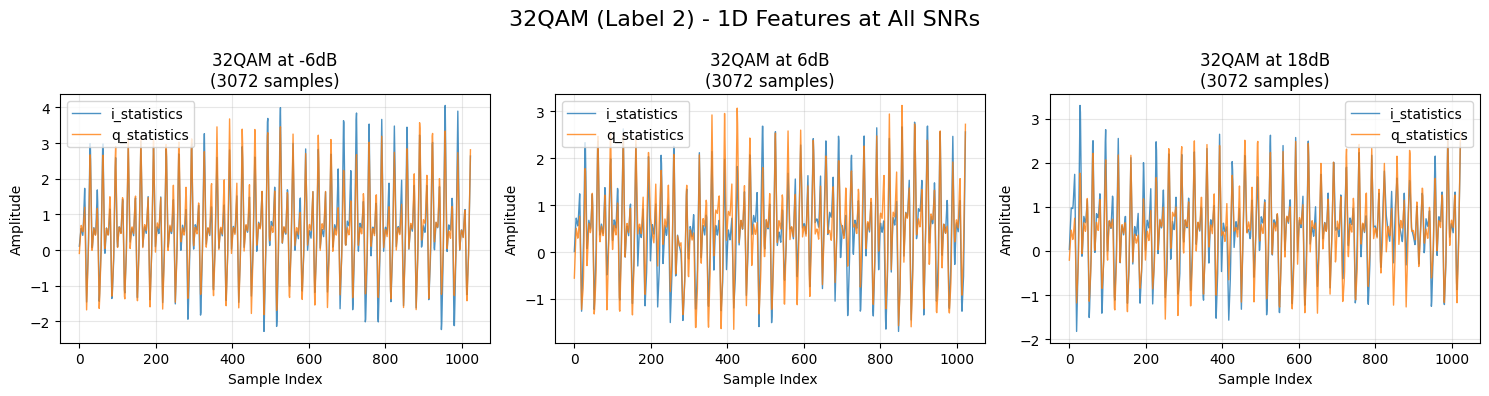

✅ Saved: sample_1d_32QAM_label2_statistical.png

🩺 DIAGNOSIS:
✅ 32QAM data looks good!

✨ Visualization complete!


In [11]:
def visualize_1d_samples_by_modulation_with_debug():
    """Visualize 1D features for each modulation with comprehensive debugging."""
    print(f"\n🔍 Starting visualization with debugging...")
    
    # Load data
    train_file = os.path.join(OUTPUT_DIR, f'train_{FEATURE_METHOD}.h5')
    try:
        with h5py.File(train_file, 'r') as f:
            features1 = f['feature1'][:]
            features2 = f['feature2'][:]
            labels = f['labels'][:]
            snrs = f['snrs'][:]
            feature1_name = safe_decode_attr(f.attrs['feature1_name'])
            feature2_name = safe_decode_attr(f.attrs['feature2_name'])
            
        print(f"✅ Successfully loaded data from: {train_file}")
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return
    
    # ==================== COMPREHENSIVE DEBUGGING ====================
    print(f"\n📊 DATA ANALYSIS:")
    print(f"Features1 shape: {features1.shape}")
    print(f"Features2 shape: {features2.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"SNRs shape: {snrs.shape}")
    print(f"Feature1 name: {feature1_name}")
    print(f"Feature2 name: {feature2_name}")
    
    print(f"\n🏷️  LABEL ANALYSIS:")
    unique_labels = np.unique(labels)
    print(f"Unique labels in data: {unique_labels}")
    print(f"Label distribution: {dict(zip(unique_labels, np.bincount(labels)))}")
    
    print(f"\n📡 SNR ANALYSIS:")
    unique_snrs = np.unique(snrs)
    print(f"Unique SNRs in data: {unique_snrs}")
    print(f"TARGET_SNRS expected: {TARGET_SNRS}")
    
    print(f"\n🎯 MODULATION MAPPING:")
    print(f"NUM_CLASSES: {NUM_CLASSES}")
    print(f"TARGET_MODULATIONS: {TARGET_MODULATIONS}")
    print(f"TARGET_MODULATIONS[:NUM_CLASSES]: {TARGET_MODULATIONS[:NUM_CLASSES]}")
    
    # Expected mapping based on the original output
    expected_mapping = {0: '8PSK', 1: '16QAM', 2: '32QAM'}
    print(f"Expected label mapping: {expected_mapping}")
    
    # Check samples for each combination
    print(f"\n🔍 SAMPLE COUNT ANALYSIS:")
    for label in unique_labels:
        label_name = expected_mapping.get(label, f"Unknown_{label}")
        total_samples = np.sum(labels == label)
        print(f"\nLabel {label} ({label_name}): {total_samples} total samples")
        
        for snr in unique_snrs:
            count = np.sum((labels == label) & (snrs == snr))
            print(f"  - at {snr}dB: {count} samples")
    
    # ==================== VISUALIZATION ====================
    print(f"\n🎨 Starting visualization...")
    
    # Use the actual unique labels instead of assuming 0,1,2...
    for label_idx in unique_labels:
        if label_idx >= len(TARGET_MODULATIONS):
            mod_name = f"Unknown_Modulation_{label_idx}"
            print(f"⚠️  Warning: Label {label_idx} exceeds TARGET_MODULATIONS length")
        else:
            mod_name = TARGET_MODULATIONS[label_idx]
        
        print(f"\n📈 Processing {mod_name} (label {label_idx})...")
        
        # Create subplots for each SNR
        fig, axes = plt.subplots(1, len(unique_snrs), figsize=(5 * len(unique_snrs), 4))
        if len(unique_snrs) == 1:
            axes = [axes]  # Handle single SNR case
            
        fig.suptitle(f'{mod_name} (Label {label_idx}) - 1D Features at All SNRs', fontsize=16)
        
        for j, snr in enumerate(unique_snrs):
            # Find samples for this modulation and SNR
            mask = (labels == label_idx) & (snrs == snr)
            idxs = np.where(mask)[0]
            
            print(f"  - {mod_name} at {snr}dB: found {len(idxs)} samples")
            
            if len(idxs) == 0:
                axes[j].set_title(f"{mod_name} at {snr}dB\n(No samples)")
                axes[j].text(0.5, 0.5, 'No Data', ha='center', va='center', 
                           transform=axes[j].transAxes, fontsize=14, color='red')
                axes[j].axis('off')
                continue
            
            # Use the first sample for visualization
            idx = idxs[0]
            x_axis = np.arange(len(features1[idx]))
            
            # Plot both features
            axes[j].plot(x_axis, features1[idx], label=feature1_name, alpha=0.8, linewidth=1)
            axes[j].plot(x_axis, features2[idx], label=feature2_name, alpha=0.8, linewidth=1)
            
            axes[j].set_title(f"{mod_name} at {snr}dB\n({len(idxs)} samples)")
            axes[j].set_xlabel('Sample Index')
            axes[j].set_ylabel('Amplitude')
            axes[j].legend()
            axes[j].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the plot
        filename = f'sample_1d_{mod_name}_label{label_idx}_{FEATURE_METHOD}.png'
        plt.savefig(os.path.join(OUTPUT_DIR, filename), dpi=150, bbox_inches='tight')
        plt.show()
        print(f"✅ Saved: {filename}")
    
    # ==================== FINAL DIAGNOSIS ====================
    print(f"\n🩺 DIAGNOSIS:")
    if 2 not in unique_labels:
        print(f"❌ 32QAM issue: Label 2 is missing from the data!")
        print(f"   - Your data only contains labels: {unique_labels}")
        print(f"   - Expected labels: [0, 1, 2] for [8PSK, 16QAM, 32QAM]")
        if NUM_CLASSES < 3:
            print(f"   - NUM_CLASSES is {NUM_CLASSES}, which might exclude 32QAM")
        print(f"   - Check your data preprocessing or feature extraction pipeline")
    elif np.sum(labels == 2) == 0:
        print(f"❌ 32QAM issue: Label 2 exists but has 0 samples!")
    else:
        print(f"✅ 32QAM data looks good!")
    
    print(f"\n✨ Visualization complete!")

# Call the function
visualize_1d_samples_by_modulation_with_debug()

### Configuration 

In [12]:
# Training configuration
BATCH_SIZE = 512
LEARNING_RATE = 0.002
NUM_EPOCHS = 100
PATIENCE = 10  # Early stopping patience
MIN_DELTA = 0.001  # Minimum improvement for early stopping

# Model configuration
DROPOUT_RATE = 0.5
NUM_CLASSES = len(TARGET_MODULATIONS)  # 8PSK vs 16QAM

# Data paths
DATA_DIR = OUTPUT_DIR  # Adjust path as needed
#FEATURE_METHOD = 'amplitude_phase'  # Change based on your preprocessing

# Output paths
RESULTS_DIR = './training_results'
MODEL_SAVE_PATH = os.path.join(RESULTS_DIR, f'best_model_{FEATURE_METHOD}.pth')
PLOTS_DIR = os.path.join(RESULTS_DIR, 'plots')

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {DEVICE}")

# Create directories
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

🚀 Using device: cuda


In [13]:
# Cell 1: Enhanced CNN Branches with Deeper Layers
class CNN1D_Shallow(nn.Module):
    """Enhanced shallow branch with more layers"""
    def __init__(self, input_size, dropout_rate=0.3):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
        )
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x shape: (batch, 1, seq_len)
        x = self.conv_block1(x)
        x = self.pool(x)
        x = self.dropout(x)
        
        x = self.conv_block2(x)
        x = self.pool(x)
        x = self.dropout(x)
        
        return x  # Keep temporal dimension

class CNN1D_Deep(nn.Module):
    """Enhanced deep branch with more layers"""
    def __init__(self, input_size, dropout_rate=0.3):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
        )
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.pool(x)
        x = self.dropout(x)
        
        x = self.conv_block2(x)
        x = self.pool(x)
        x = self.dropout(x)
        
        x = self.conv_block3(x)
        x = self.pool(x)
        x = self.dropout(x)
        
        return x  # Keep temporal dimension

# Cell 2: Fixed LSTM Integration
class DiagramModel1D(nn.Module):
    """1D model with proper LSTM integration"""
    def __init__(self, input_size, num_classes, dropout_rate=0.4):
        super().__init__()
        self.cnn1 = CNN1D_Shallow(input_size, dropout_rate)
        self.cnn2 = CNN1D_Deep(input_size, dropout_rate)
        
        # Calculate output channels after CNN processing
        self.shallow_out_channels = 128
        self.deep_out_channels = 256
        
        # LSTM input size (shallow + deep channels)
        lstm_input_size = self.shallow_out_channels + self.deep_out_channels
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(512, 128),  # 256*2 (bidirectional)
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
            
        # Process through both branches
        shallow_out = self.cnn1(x)  # (batch, 128, seq_len/4)
        deep_out = self.cnn2(x)     # (batch, 256, seq_len/8)
        
        # Adjust sequence lengths using adaptive pooling
        target_length = min(shallow_out.size(2), deep_out.size(2))
        shallow_out = F.adaptive_avg_pool1d(shallow_out, target_length)
        deep_out = F.adaptive_avg_pool1d(deep_out, target_length)
        
        # Concatenate along channel dimension
        fused = torch.cat((shallow_out, deep_out), dim=1)  # (batch, 384, seq_len)
        
        # Permute for LSTM: (batch, seq_len, features)
        lstm_input = fused.permute(0, 2, 1)
        
        # LSTM processing
        lstm_out, _ = self.lstm(lstm_input)  # (batch, seq_len, 512)
        
        # Attention mechanism
        attention_weights = self.attention(lstm_out)  # (batch, seq_len, 1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # (batch, 512)
        
        # Classification
        output = self.classifier(context_vector)
        return output

# Cell 3: Dual-Channel Processing Model
class DiagramIQModel1D(nn.Module):
    """1D model for I/Q dual-channel processing"""
    def __init__(self, input_size, num_classes, dropout_rate=0.5):
        super().__init__()
        self.feature1_branch = DiagramModel1D(input_size, num_classes, dropout_rate)
        self.feature2_branch = DiagramModel1D(input_size, num_classes, dropout_rate)
        
        # Feature fusion
        self.fusion = nn.Sequential(
            nn.Linear(num_classes * 2, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, feature1, feature2):
        out1 = self.feature1_branch(feature1)
        out2 = self.feature2_branch(feature2)
        
        # Concatenate and fuse
        combined = torch.cat([out1, out2], dim=1)
        output = self.fusion(combined)
        return output

In [14]:
class RadioMLDataset(Dataset):
    """Dataset class for RadioML 1D preprocessed data"""
    
    def __init__(self, hdf5_path):
        self.hdf5_path = hdf5_path
        
        with h5py.File(hdf5_path, 'r') as f:
            self.feature1 = f['feature1'][:]
            self.feature2 = f['feature2'][:]
            self.labels = f['labels'][:]
            self.snrs = f['snrs'][:]
            
            # Load metadata
            self.num_samples = f.attrs['num_samples']
            self.feature_method = f.attrs['feature_method']
            if isinstance(self.feature_method, bytes):
                self.feature_method = self.feature_method.decode('utf-8')
                
            self.feature_length = f.attrs.get('feature_length', self.feature1.shape[1])
        
        print(f"📊 Loaded dataset: {self.num_samples} samples")
        print(f"   Feature method: {self.feature_method}")
        print(f"   Feature shapes: {self.feature1.shape}, {self.feature2.shape}")
        
        # FIX: Class distribution with proper mapping
        unique, counts = np.unique(self.labels, return_counts=True)
        for label, count in zip(unique, counts):
            if label < len(TARGET_MODULATIONS):
                mod_name = TARGET_MODULATIONS[label]  # FIX: Use TARGET_MODULATIONS list
            else:
                mod_name = f"Unknown_Label_{label}"
            print(f"   {mod_name}: {count} samples")
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if idx == 0: 
            print(f"🔍 Fetching item {idx} from dataset")
        feature1 = torch.FloatTensor(self.feature1[idx])
        feature2 = torch.FloatTensor(self.feature2[idx])
        label = torch.LongTensor([self.labels[idx]])[0]
        snr = self.snrs[idx]
        
        return feature1, feature2, label, snr

In [15]:
class EarlyStopping:
    """Early stopping utility"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
        else:
            self.best_score = val_score
            self.counter = 0
        
        return self.counter >= self.patience

In [16]:
def create_data_loaders():
    """Create train and validation data loaders"""
    train_path = os.path.join(DATA_DIR, f'train_{FEATURE_METHOD}.h5')
    valid_path = os.path.join(DATA_DIR, f'valid_{FEATURE_METHOD}.h5')
    
    # Check file existence
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Training data not found: {train_path}")
    if not os.path.exists(valid_path):
        raise FileNotFoundError(f"Validation data not found: {valid_path}")
    
    # Create datasets and loaders
    train_dataset = RadioMLDataset(train_path)
    valid_dataset = RadioMLDataset(valid_path)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=0,
        pin_memory=True if DEVICE.type == 'cuda' else False
    )
    
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True if DEVICE.type == 'cuda' else False
    )
    
    return train_loader, valid_loader, train_dataset.feature_length

In [17]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc="Training")
    for feature1, feature2, labels, snrs in pbar:
        feature1 = feature1.to(device)
        feature2 = feature2.to(device) 
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(feature1, feature2)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_epoch(model, valid_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    all_snrs = []
    
    with torch.no_grad():
        pbar = tqdm(valid_loader, desc="Validation")
        for feature1, feature2, labels, snrs in pbar:
            feature1 = feature1.to(device)
            feature2 = feature2.to(device)
            labels = labels.to(device)
            
            outputs = model(feature1, feature2)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    avg_loss = total_loss / len(valid_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy, all_predictions, all_labels, all_snrs

In [18]:
from collections import defaultdict
def train_model():
    """Main training function"""
    print(f"🎯 Starting Focused Training: {TARGET_MODULATIONS}")
    print("=" * 60)
    
    # Create data loaders
    train_loader, valid_loader, feature_length = create_data_loaders()
    
    # Initialize model
    model = DiagramIQModel1D(
        input_size=feature_length,
        num_classes=NUM_CLASSES,
        dropout_rate=DROPOUT_RATE
    ).to(DEVICE)
    
    # Print model info
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"🧠 Model: DiagramIQModel1D")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Feature length: {feature_length}")
    print(f"   Classes: {NUM_CLASSES}")
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2, eta_min=1e-6)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)
    
    # Training history
    history = defaultdict(list)
    best_val_acc = 0
    best_epoch = 0
    
    print(f"\n🚀 Training started...")
    start_time = time.time()
    
    for epoch in range(NUM_EPOCHS):
        print(f"\n📈 Epoch {epoch+1}/{NUM_EPOCHS}")
        print("-" * 40)
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
        
        # Validation  
        val_loss, val_acc, val_preds, val_labels, val_snrs = validate_epoch(
            model, valid_loader, criterion, DEVICE
        )
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Print epoch results
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"Valid - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'feature_method': FEATURE_METHOD
            }, MODEL_SAVE_PATH)
            print(f"💾 New best model saved! (Acc: {val_acc:.2f}%)")
        
        # Early stopping check
        if early_stopping(val_acc):
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
            break
    
    total_time = time.time() - start_time
    print(f"\n✅ Training completed!")
    print(f"   Total time: {total_time/60:.1f} minutes")
    print(f"   Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
    
    return history, model

In [19]:
def evaluate_model():
    """Evaluate the trained model and create visualizations"""
    print("\n🔍 Evaluating trained model...")
    
    # Load data
    train_loader, valid_loader, feature_length = create_data_loaders()
    
    # Load best model
    model = DiagramIQModel1D(
        input_size=feature_length,
        num_classes=NUM_CLASSES,
        dropout_rate=DROPOUT_RATE
    ).to(DEVICE)
    
    checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"📁 Loaded model from epoch {checkpoint['epoch']+1}")
    
    # Evaluate
    criterion = nn.CrossEntropyLoss()
    val_loss, val_acc, val_preds, val_labels, val_snrs = validate_epoch(
        model, valid_loader, criterion, DEVICE
    )
    
    # Calculate metrics
    f1 = f1_score(val_labels, val_preds, average='weighted')
    
    print(f"📊 Final Results:")
    print(f"   Accuracy: {val_acc:.2f}%")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   Loss: {val_loss:.4f}")
    
    # FIX: Use TARGET_MODULATIONS instead of hardcoded class names
    class_names = TARGET_MODULATIONS[:NUM_CLASSES]  # ['8PSK', '16QAM', '32QAM']
    print(f"\n📋 Classification Report:")
    print(classification_report(val_labels, val_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(val_labels, val_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(PLOTS_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Performance by SNR
    snr_results = {}
    for snr in np.unique(val_snrs):
        mask = np.array(val_snrs) == snr
        snr_acc = accuracy_score(np.array(val_labels)[mask], np.array(val_preds)[mask])
        snr_results[snr] = snr_acc * 100
        print(f"   SNR {snr:2.0f}dB: {snr_acc*100:.2f}%")
    
    # Plot SNR performance
    plt.figure(figsize=(10, 6))
    snrs = sorted(snr_results.keys())
    accs = [snr_results[snr] for snr in snrs]
    
    plt.plot(snrs, accs, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy (%)')
    plt.title('Classification Accuracy vs SNR')
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 100])
    
    for snr, acc in zip(snrs, accs):
        plt.annotate(f'{acc:.1f}%', (snr, acc), textcoords="offset points", 
                    xytext=(0,10), ha='center')
    
    plt.savefig(os.path.join(PLOTS_DIR, 'accuracy_vs_snr.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    return val_acc, f1

In [20]:
history, model = train_model()

🎯 Starting Focused Training: ['8PSK', '16QAM', '32QAM']
📊 Loaded dataset: 27648 samples
   Feature method: statistical
   Feature shapes: (27648, 1024), (27648, 1024)
   8PSK: 9216 samples
   16QAM: 9216 samples
   32QAM: 9216 samples
📊 Loaded dataset: 9216 samples
   Feature method: statistical
   Feature shapes: (9216, 1024), (9216, 1024)
   8PSK: 3072 samples
   16QAM: 3072 samples
   32QAM: 3072 samples
🧠 Model: DiagramIQModel1D
   Total parameters: 7,157,515
   Feature length: 1024
   Classes: 3

🚀 Training started...

📈 Epoch 1/100
----------------------------------------


Training:  54%|█████▎    | 29/54 [00:22<00:19,  1.30it/s, Loss=1.0784, Acc=34.56%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  8.67it/s, Loss=1.3090, Acc=0.00%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.21it/s, Loss=0.9908, Acc=34.16%]


Train - Loss: 1.0898, Acc: 36.78%
Valid - Loss: 1.1051, Acc: 34.16%
Learning Rate: 0.001985
💾 New best model saved! (Acc: 34.16%)

📈 Epoch 2/100
----------------------------------------


Training:  72%|███████▏  | 39/54 [00:29<00:11,  1.30it/s, Loss=1.0572, Acc=42.71%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.57it/s, Loss=1.0405, Acc=99.90%] 

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.78it/s, Loss=1.0276, Acc=45.04%]


Train - Loss: 1.0554, Acc: 43.14%
Valid - Loss: 1.0301, Acc: 45.04%
Learning Rate: 0.001987
💾 New best model saved! (Acc: 45.04%)

📈 Epoch 3/100
----------------------------------------


Training:  89%|████████▉ | 48/54 [00:37<00:04,  1.29it/s, Loss=1.0677, Acc=46.34%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.01it/s, Loss=1.1345, Acc=0.00%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.33it/s, Loss=1.1227, Acc=48.68%]


Train - Loss: 1.0236, Acc: 46.49%
Valid - Loss: 0.9980, Acc: 48.68%
Learning Rate: 0.001988
💾 New best model saved! (Acc: 48.68%)

📈 Epoch 4/100
----------------------------------------


Training:  76%|███████▌  | 41/54 [00:31<00:09,  1.30it/s, Loss=1.0263, Acc=48.69%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.71it/s, Loss=1.1044, Acc=24.80%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.39it/s, Loss=0.9939, Acc=51.11%]


Train - Loss: 1.0009, Acc: 49.04%
Valid - Loss: 0.9748, Acc: 51.11%
Learning Rate: 0.001988
💾 New best model saved! (Acc: 51.11%)

📈 Epoch 5/100
----------------------------------------


Training:  41%|████      | 22/54 [00:16<00:24,  1.28it/s, Loss=1.0136, Acc=49.48%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  8.59it/s, Loss=1.1171, Acc=0.00%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.18it/s, Loss=0.9540, Acc=50.03%]


Train - Loss: 0.9937, Acc: 49.79%
Valid - Loss: 0.9876, Acc: 50.03%
Learning Rate: 0.001988

📈 Epoch 6/100
----------------------------------------


Training:  48%|████▊     | 26/54 [00:20<00:21,  1.28it/s, Loss=1.0286, Acc=51.20%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.57it/s, Loss=1.1378, Acc=0.00%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.30it/s, Loss=1.0325, Acc=51.93%]


Train - Loss: 0.9825, Acc: 51.14%
Valid - Loss: 0.9663, Acc: 51.93%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 51.93%)

📈 Epoch 7/100
----------------------------------------


Training:  69%|██████▊   | 37/54 [00:28<00:13,  1.29it/s, Loss=0.9589, Acc=51.62%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.47it/s, Loss=1.1326, Acc=0.00%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.61it/s, Loss=0.9469, Acc=53.19%]


Train - Loss: 0.9751, Acc: 51.66%
Valid - Loss: 0.9579, Acc: 53.19%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 53.19%)

📈 Epoch 8/100
----------------------------------------


Training:  31%|███▏      | 17/54 [00:13<00:28,  1.29it/s, Loss=0.9500, Acc=51.88%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.90it/s, Loss=1.1148, Acc=0.00%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.55it/s, Loss=1.1172, Acc=50.00%]


Train - Loss: 0.9697, Acc: 51.93%
Valid - Loss: 0.9897, Acc: 50.00%
Learning Rate: 0.001988

📈 Epoch 9/100
----------------------------------------


Training:  78%|███████▊  | 42/54 [00:32<00:09,  1.30it/s, Loss=0.9745, Acc=52.42%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.56it/s, Loss=1.1060, Acc=0.00%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.06it/s, Loss=0.9857, Acc=53.47%]


Train - Loss: 0.9717, Acc: 52.58%
Valid - Loss: 0.9532, Acc: 53.47%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 53.47%)

📈 Epoch 10/100
----------------------------------------


Training:  69%|██████▊   | 37/54 [00:28<00:12,  1.31it/s, Loss=0.9757, Acc=53.14%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  8.71it/s, Loss=1.1053, Acc=7.62%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.43it/s, Loss=0.9295, Acc=52.82%]


Train - Loss: 0.9617, Acc: 52.88%
Valid - Loss: 0.9584, Acc: 52.82%
Learning Rate: 0.001989

📈 Epoch 11/100
----------------------------------------


Training:  37%|███▋      | 20/54 [00:15<00:26,  1.31it/s, Loss=0.9762, Acc=52.77%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.30it/s, Loss=1.0856, Acc=75.00%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.36it/s, Loss=0.9683, Acc=54.04%]


Train - Loss: 0.9565, Acc: 53.33%
Valid - Loss: 0.9491, Acc: 54.04%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 54.04%)

📈 Epoch 12/100
----------------------------------------


Training:  44%|████▍     | 24/54 [00:18<00:23,  1.30it/s, Loss=0.9659, Acc=53.87%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.14it/s, Loss=1.1021, Acc=3.91%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.53it/s, Loss=0.9530, Acc=53.97%]


Train - Loss: 0.9587, Acc: 53.61%
Valid - Loss: 0.9484, Acc: 53.97%
Learning Rate: 0.001989

📈 Epoch 13/100
----------------------------------------


Training:  24%|██▍       | 13/54 [00:10<00:34,  1.20it/s, Loss=0.9600, Acc=53.23%]

🔍 Fetching item 0 from dataset


Validation:   0%|          | 0/18 [00:00<?, ?it/s, Loss=1.1256, Acc=0.10%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.73it/s, Loss=0.9375, Acc=53.90%]


Train - Loss: 0.9544, Acc: 53.45%
Valid - Loss: 0.9451, Acc: 53.90%
Learning Rate: 0.001989

📈 Epoch 14/100
----------------------------------------


Training:  28%|██▊       | 15/54 [00:10<00:26,  1.47it/s, Loss=0.9525, Acc=54.26%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.15it/s, Loss=1.1063, Acc=6.05%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.19it/s, Loss=0.9744, Acc=53.59%]


Train - Loss: 0.9551, Acc: 54.03%
Valid - Loss: 0.9521, Acc: 53.59%
Learning Rate: 0.001989

📈 Epoch 15/100
----------------------------------------


Training:  33%|███▎      | 18/54 [00:13<00:27,  1.29it/s, Loss=0.9568, Acc=53.86%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  8.95it/s, Loss=1.0886, Acc=32.23%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.36it/s, Loss=0.9060, Acc=53.74%]


Train - Loss: 0.9542, Acc: 53.76%
Valid - Loss: 0.9467, Acc: 53.74%
Learning Rate: 0.001989

📈 Epoch 16/100
----------------------------------------


Training:  93%|█████████▎| 50/54 [00:38<00:03,  1.31it/s, Loss=0.9386, Acc=54.59%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.09it/s, Loss=1.1180, Acc=0.20%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.06it/s, Loss=0.9540, Acc=54.30%]


Train - Loss: 0.9505, Acc: 54.57%
Valid - Loss: 0.9431, Acc: 54.30%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 54.30%)

📈 Epoch 17/100
----------------------------------------


Training:   6%|▌         | 3/54 [00:02<00:38,  1.31it/s, Loss=0.9465, Acc=56.58%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.24it/s, Loss=1.1277, Acc=0.00%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.28it/s, Loss=0.9289, Acc=54.25%]


Train - Loss: 0.9444, Acc: 54.78%
Valid - Loss: 0.9407, Acc: 54.25%
Learning Rate: 0.001989

📈 Epoch 18/100
----------------------------------------


Training:  56%|█████▌    | 30/54 [00:23<00:18,  1.31it/s, Loss=0.9681, Acc=55.32%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.01it/s, Loss=1.0772, Acc=97.07%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.19it/s, Loss=0.8730, Acc=53.45%]


Train - Loss: 0.9457, Acc: 55.28%
Valid - Loss: 0.9492, Acc: 53.45%
Learning Rate: 0.001989

📈 Epoch 19/100
----------------------------------------


Training:  76%|███████▌  | 41/54 [00:31<00:10,  1.29it/s, Loss=0.9356, Acc=55.08%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.20it/s, Loss=1.1124, Acc=1.37%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.31it/s, Loss=0.9715, Acc=54.33%]


Train - Loss: 0.9455, Acc: 54.51%
Valid - Loss: 0.9410, Acc: 54.33%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 54.33%)

📈 Epoch 20/100
----------------------------------------


Training:  91%|█████████ | 49/54 [00:37<00:03,  1.30it/s, Loss=0.9142, Acc=55.42%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.62it/s, Loss=1.0920, Acc=65.43%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.39it/s, Loss=0.9771, Acc=53.85%]


Train - Loss: 0.9433, Acc: 55.34%
Valid - Loss: 0.9476, Acc: 53.85%
Learning Rate: 0.001989

📈 Epoch 21/100
----------------------------------------


Training:  78%|███████▊  | 42/54 [00:32<00:09,  1.30it/s, Loss=0.9302, Acc=55.23%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  8.55it/s, Loss=1.0754, Acc=94.53%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.25it/s, Loss=0.9397, Acc=54.70%]


Train - Loss: 0.9416, Acc: 55.16%
Valid - Loss: 0.9421, Acc: 54.70%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 54.70%)

📈 Epoch 22/100
----------------------------------------


Training:  80%|███████▉  | 43/54 [00:33<00:08,  1.30it/s, Loss=0.9357, Acc=56.42%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.43it/s, Loss=1.0613, Acc=99.12%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.37it/s, Loss=0.9378, Acc=54.25%]


Train - Loss: 0.9365, Acc: 55.89%
Valid - Loss: 0.9446, Acc: 54.25%
Learning Rate: 0.001989

📈 Epoch 23/100
----------------------------------------


Training:  50%|█████     | 27/54 [00:20<00:20,  1.31it/s, Loss=0.9438, Acc=55.77%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.43it/s, Loss=1.0914, Acc=51.17%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.31it/s, Loss=0.9608, Acc=54.52%]


Train - Loss: 0.9334, Acc: 55.76%
Valid - Loss: 0.9427, Acc: 54.52%
Learning Rate: 0.001989

📈 Epoch 24/100
----------------------------------------


Training:  15%|█▍        | 8/54 [00:06<00:35,  1.31it/s, Loss=0.9278, Acc=55.64%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  8.72it/s, Loss=1.0979, Acc=38.67%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.39it/s, Loss=0.8958, Acc=55.02%]


Train - Loss: 0.9344, Acc: 55.56%
Valid - Loss: 0.9317, Acc: 55.02%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 55.02%)

📈 Epoch 25/100
----------------------------------------


Training:  43%|████▎     | 23/54 [00:17<00:24,  1.29it/s, Loss=0.9329, Acc=56.22%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.07it/s, Loss=1.1160, Acc=0.39%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.19it/s, Loss=0.9390, Acc=54.48%]


Train - Loss: 0.9305, Acc: 56.55%
Valid - Loss: 0.9393, Acc: 54.48%
Learning Rate: 0.001989

📈 Epoch 26/100
----------------------------------------


Training:  98%|█████████▊| 53/54 [00:40<00:00,  1.32it/s, Loss=0.9296, Acc=56.45%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.15it/s, Loss=1.1117, Acc=5.27%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.35it/s, Loss=0.9163, Acc=55.31%]


Train - Loss: 0.9320, Acc: 56.39%
Valid - Loss: 0.9333, Acc: 55.31%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 55.31%)

📈 Epoch 27/100
----------------------------------------


Training:  61%|██████    | 33/54 [00:25<00:16,  1.29it/s, Loss=0.9410, Acc=56.71%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.12it/s, Loss=1.1060, Acc=21.88%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.25it/s, Loss=0.9035, Acc=55.27%]


Train - Loss: 0.9293, Acc: 56.80%
Valid - Loss: 0.9326, Acc: 55.27%
Learning Rate: 0.001989

📈 Epoch 28/100
----------------------------------------


Training:  20%|██        | 11/54 [00:08<00:32,  1.30it/s, Loss=0.9229, Acc=56.13%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.26it/s, Loss=1.1078, Acc=8.59%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.23it/s, Loss=0.9649, Acc=54.00%]


Train - Loss: 0.9256, Acc: 56.78%
Valid - Loss: 0.9464, Acc: 54.00%
Learning Rate: 0.001989

📈 Epoch 29/100
----------------------------------------


Training:  11%|█         | 6/54 [00:04<00:36,  1.31it/s, Loss=0.9227, Acc=57.26%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  8.91it/s, Loss=1.0863, Acc=81.64%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.42it/s, Loss=0.8901, Acc=55.09%]


Train - Loss: 0.9277, Acc: 56.64%
Valid - Loss: 0.9356, Acc: 55.09%
Learning Rate: 0.001989

📈 Epoch 30/100
----------------------------------------


Training:  48%|████▊     | 26/54 [00:19<00:21,  1.29it/s, Loss=0.9373, Acc=57.72%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  8.57it/s, Loss=1.0764, Acc=92.77%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.97it/s, Loss=0.8782, Acc=55.21%]


Train - Loss: 0.9265, Acc: 56.86%
Valid - Loss: 0.9308, Acc: 55.21%
Learning Rate: 0.001989

📈 Epoch 31/100
----------------------------------------


Training:  50%|█████     | 27/54 [00:20<00:20,  1.31it/s, Loss=0.9097, Acc=57.05%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.01it/s, Loss=1.0932, Acc=59.96%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.17it/s, Loss=0.8785, Acc=55.21%]


Train - Loss: 0.9237, Acc: 57.51%
Valid - Loss: 0.9306, Acc: 55.21%
Learning Rate: 0.001989

📈 Epoch 32/100
----------------------------------------


Training:  26%|██▌       | 14/54 [00:10<00:30,  1.29it/s, Loss=0.9248, Acc=58.36%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.28it/s, Loss=1.0713, Acc=96.09%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.29it/s, Loss=0.9232, Acc=55.43%]


Train - Loss: 0.9173, Acc: 57.91%
Valid - Loss: 0.9333, Acc: 55.43%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 55.43%)

📈 Epoch 33/100
----------------------------------------


Training:  72%|███████▏  | 39/54 [00:30<00:11,  1.31it/s, Loss=0.9119, Acc=57.90%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.62it/s, Loss=1.0734, Acc=96.48%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.28it/s, Loss=0.9327, Acc=54.61%]


Train - Loss: 0.9180, Acc: 57.78%
Valid - Loss: 0.9407, Acc: 54.61%
Learning Rate: 0.001989

📈 Epoch 34/100
----------------------------------------


Training:   7%|▋         | 4/54 [00:03<00:38,  1.30it/s, Loss=0.9004, Acc=59.47%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  8.77it/s, Loss=1.0949, Acc=46.09%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.17it/s, Loss=0.8770, Acc=55.21%]


Train - Loss: 0.9146, Acc: 58.14%
Valid - Loss: 0.9338, Acc: 55.21%
Learning Rate: 0.001989

📈 Epoch 35/100
----------------------------------------


Training:  22%|██▏       | 12/54 [00:09<00:31,  1.31it/s, Loss=0.8937, Acc=59.03%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  8.77it/s, Loss=1.0964, Acc=30.86%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.39it/s, Loss=0.9274, Acc=55.32%]


Train - Loss: 0.9159, Acc: 58.03%
Valid - Loss: 0.9412, Acc: 55.32%
Learning Rate: 0.001989

📈 Epoch 36/100
----------------------------------------


Training:  65%|██████▍   | 35/54 [00:26<00:14,  1.30it/s, Loss=0.9311, Acc=58.18%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:02,  8.06it/s, Loss=1.1165, Acc=0.00%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.30it/s, Loss=0.8840, Acc=55.72%]


Train - Loss: 0.9141, Acc: 58.50%
Valid - Loss: 0.9296, Acc: 55.72%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 55.72%)

📈 Epoch 37/100
----------------------------------------


Training:  33%|███▎      | 18/54 [00:13<00:27,  1.31it/s, Loss=0.8972, Acc=59.39%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.85it/s, Loss=1.0770, Acc=76.95%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.54it/s, Loss=0.9082, Acc=54.46%]


Train - Loss: 0.9079, Acc: 59.23%
Valid - Loss: 0.9476, Acc: 54.46%
Learning Rate: 0.001989

📈 Epoch 38/100
----------------------------------------


Training:  69%|██████▊   | 37/54 [00:28<00:13,  1.29it/s, Loss=0.9018, Acc=58.91%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:02,  8.40it/s, Loss=1.1061, Acc=8.01%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.46it/s, Loss=0.9078, Acc=55.35%]


Train - Loss: 0.9090, Acc: 58.76%
Valid - Loss: 0.9317, Acc: 55.35%
Learning Rate: 0.001989

📈 Epoch 39/100
----------------------------------------


Training:  91%|█████████ | 49/54 [00:37<00:03,  1.29it/s, Loss=0.9163, Acc=58.60%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.26it/s, Loss=1.0804, Acc=78.12%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.52it/s, Loss=1.0289, Acc=53.47%]


Train - Loss: 0.9126, Acc: 58.66%
Valid - Loss: 0.9602, Acc: 53.47%
Learning Rate: 0.001989

📈 Epoch 40/100
----------------------------------------


Training:  67%|██████▋   | 36/54 [00:27<00:13,  1.30it/s, Loss=0.8910, Acc=58.82%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  8.77it/s, Loss=1.1104, Acc=4.69%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.52it/s, Loss=0.9466, Acc=55.47%]


Train - Loss: 0.9099, Acc: 58.99%
Valid - Loss: 0.9365, Acc: 55.47%
Learning Rate: 0.001989

📈 Epoch 41/100
----------------------------------------


Training:  78%|███████▊  | 42/54 [00:32<00:09,  1.28it/s, Loss=0.9254, Acc=59.87%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:02,  8.46it/s, Loss=1.0757, Acc=77.34%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.49it/s, Loss=0.9511, Acc=55.46%]


Train - Loss: 0.9014, Acc: 59.74%
Valid - Loss: 0.9346, Acc: 55.46%
Learning Rate: 0.001989

📈 Epoch 42/100
----------------------------------------


Training:  54%|█████▎    | 29/54 [00:22<00:19,  1.31it/s, Loss=0.8992, Acc=61.05%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.52it/s, Loss=1.1176, Acc=11.33%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.58it/s, Loss=0.9076, Acc=56.17%]


Train - Loss: 0.8993, Acc: 60.39%
Valid - Loss: 0.9315, Acc: 56.17%
Learning Rate: 0.001989
💾 New best model saved! (Acc: 56.17%)

📈 Epoch 43/100
----------------------------------------


Training:  98%|█████████▊| 53/54 [00:40<00:00,  1.32it/s, Loss=0.9235, Acc=60.31%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.40it/s, Loss=1.1176, Acc=6.84%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.51it/s, Loss=0.9115, Acc=54.83%]


Train - Loss: 0.8982, Acc: 60.27%
Valid - Loss: 0.9448, Acc: 54.83%
Learning Rate: 0.001989

📈 Epoch 44/100
----------------------------------------


Training:  89%|████████▉ | 48/54 [00:37<00:04,  1.30it/s, Loss=0.8782, Acc=60.27%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.39it/s, Loss=1.0606, Acc=91.60%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.49it/s, Loss=0.9881, Acc=55.22%]


Train - Loss: 0.8992, Acc: 60.30%
Valid - Loss: 0.9413, Acc: 55.22%
Learning Rate: 0.001989

📈 Epoch 45/100
----------------------------------------


Training:  80%|███████▉  | 43/54 [00:33<00:08,  1.29it/s, Loss=0.9129, Acc=60.14%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.35it/s, Loss=1.1110, Acc=8.98%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.53it/s, Loss=0.8603, Acc=55.22%]


Train - Loss: 0.8995, Acc: 60.08%
Valid - Loss: 0.9298, Acc: 55.22%
Learning Rate: 0.001989

📈 Epoch 46/100
----------------------------------------


Training:  94%|█████████▍| 51/54 [00:39<00:02,  1.29it/s, Loss=0.9115, Acc=61.24%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:02,  8.20it/s, Loss=1.0942, Acc=38.28%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.48it/s, Loss=0.8841, Acc=55.53%]


Train - Loss: 0.8914, Acc: 61.15%
Valid - Loss: 0.9359, Acc: 55.53%
Learning Rate: 0.001989

📈 Epoch 47/100
----------------------------------------


Training:  13%|█▎        | 7/54 [00:05<00:36,  1.30it/s, Loss=0.9012, Acc=61.77%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.07it/s, Loss=1.0920, Acc=41.41%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.43it/s, Loss=0.8968, Acc=55.36%]


Train - Loss: 0.8919, Acc: 61.14%
Valid - Loss: 0.9333, Acc: 55.36%
Learning Rate: 0.001989

📈 Epoch 48/100
----------------------------------------


Training:  91%|█████████ | 49/54 [00:37<00:03,  1.28it/s, Loss=0.8754, Acc=61.35%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.43it/s, Loss=1.0879, Acc=62.30%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.55it/s, Loss=0.9753, Acc=55.06%]


Train - Loss: 0.8878, Acc: 61.26%
Valid - Loss: 0.9448, Acc: 55.06%
Learning Rate: 0.001989

📈 Epoch 49/100
----------------------------------------


Training:  52%|█████▏    | 28/54 [00:21<00:19,  1.32it/s, Loss=0.8733, Acc=62.59%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.17it/s, Loss=1.0809, Acc=71.88%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.55it/s, Loss=1.0104, Acc=54.97%]


Train - Loss: 0.8854, Acc: 61.90%
Valid - Loss: 0.9453, Acc: 54.97%
Learning Rate: 0.001989

📈 Epoch 50/100
----------------------------------------


Training:  87%|████████▋ | 47/54 [00:36<00:05,  1.29it/s, Loss=0.9101, Acc=62.27%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.17it/s, Loss=1.0844, Acc=69.34%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.41it/s, Loss=0.9217, Acc=53.81%]


Train - Loss: 0.8835, Acc: 61.97%
Valid - Loss: 0.9569, Acc: 53.81%
Learning Rate: 0.001989

📈 Epoch 51/100
----------------------------------------


Training:  57%|█████▋    | 31/54 [00:23<00:17,  1.29it/s, Loss=0.8841, Acc=62.07%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.21it/s, Loss=1.1046, Acc=45.02%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.49it/s, Loss=0.8809, Acc=55.23%]


Train - Loss: 0.8786, Acc: 62.31%
Valid - Loss: 0.9434, Acc: 55.23%
Learning Rate: 0.001989

📈 Epoch 52/100
----------------------------------------


Training:  89%|████████▉ | 48/54 [00:37<00:04,  1.30it/s, Loss=0.8647, Acc=62.72%]

🔍 Fetching item 0 from dataset


Validation:   6%|▌         | 1/18 [00:00<00:01,  9.43it/s, Loss=1.0901, Acc=54.10%]

🔍 Fetching item 0 from dataset


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.13it/s, Loss=0.9578, Acc=54.93%]

Train - Loss: 0.8771, Acc: 62.51%
Valid - Loss: 0.9528, Acc: 54.93%
Learning Rate: 0.001989
⏹️ Early stopping triggered at epoch 52

✅ Training completed!
   Total time: 37.7 minutes
   Best validation accuracy: 56.17% (epoch 42)


📈 Ready to create fixed analysis plots!
Run: accuracy_matrix, confusion_matrix = create_fixed_analysis_plots()
🎯 Creating fixed analysis plots...
📊 Loaded dataset: 27648 samples
   Feature method: statistical
   Feature shapes: (27648, 1024), (27648, 1024)
   8PSK: 9216 samples
   16QAM: 9216 samples
   32QAM: 9216 samples
📊 Loaded dataset: 9216 samples
   Feature method: statistical
   Feature shapes: (9216, 1024), (9216, 1024)
   8PSK: 3072 samples
   16QAM: 3072 samples
   32QAM: 3072 samples
🔍 Fetching item 0 from dataset


TypeError: 'numpy.ndarray' object is not callable

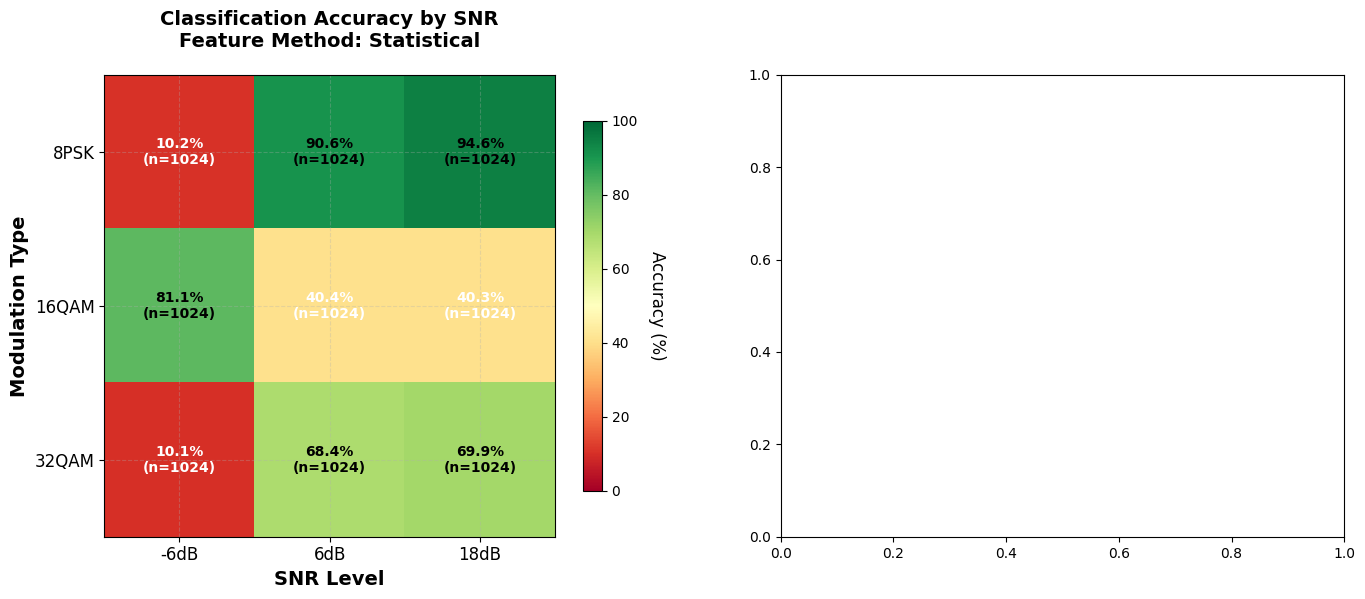

In [26]:
def create_fixed_analysis_plots():
    """Create properly formatted SNR-Modulation heatmap and confusion matrix"""
    print("🎯 Creating fixed analysis plots...")
    
    # Load data and model
    train_loader, valid_loader, feature_length = create_data_loaders()
    
    model = DiagramIQModel1D(
        input_size=feature_length,
        num_classes=NUM_CLASSES,
        dropout_rate=DROPOUT_RATE
    ).to(DEVICE)
    
    checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Get predictions
    all_preds = []
    all_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for feature1, feature2, labels, snrs in valid_loader:
            feature1 = feature1.to(DEVICE)
            feature2 = feature2.to(DEVICE)
            
            outputs = model(feature1, feature2)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_snrs.extend(snrs.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_snrs = np.array(all_snrs)
    
    # Create figure with better dimensions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ========== SNR-MODULATION HEATMAP ==========
    accuracy_matrix = np.zeros((NUM_CLASSES, len(TARGET_SNRS)))
    sample_counts = np.zeros((NUM_CLASSES, len(TARGET_SNRS)), dtype=int)
    
    for mod_idx in range(NUM_CLASSES):
        for snr_idx, snr in enumerate(TARGET_SNRS):
            mask = (all_labels == mod_idx) & (all_snrs == snr)
            total_samples = np.sum(mask)
            sample_counts[mod_idx, snr_idx] = total_samples
            
            if total_samples > 0:
                correct = np.sum(all_preds[mask] == all_labels[mask])
                accuracy_matrix[mod_idx, snr_idx] = correct / total_samples * 100
    
    # Plot heatmap with better colors
    im1 = ax1.imshow(accuracy_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
    
    # Customize heatmap
    ax1.set_xticks(range(len(TARGET_SNRS)))
    ax1.set_xticklabels([f'{snr}dB' for snr in TARGET_SNRS], fontsize=12)
    ax1.set_yticks(range(NUM_CLASSES))
    ax1.set_yticklabels(TARGET_MODULATIONS, fontsize=12)
    
    # Add text annotations with better formatting
    for mod_idx in range(NUM_CLASSES):
        for snr_idx in range(len(TARGET_SNRS)):
            accuracy = accuracy_matrix[mod_idx, snr_idx]
            samples = sample_counts[mod_idx, snr_idx]
            
            # Choose text color based on background
            text_color = 'white' if accuracy < 50 else 'black'
            
            # Format text with accuracy and sample count
            text = f'{accuracy:.1f}%\n(n={samples})'
            
            ax1.text(snr_idx, mod_idx, text,
                    ha='center', va='center', color=text_color, 
                    fontweight='bold', fontsize=10)
    
    ax1.set_xlabel('SNR Level', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Modulation Type', fontsize=14, fontweight='bold')
    ax1.set_title(f'Classification Accuracy by SNR\nFeature Method: {FEATURE_METHOD.replace("_", " ").title()}', 
                 fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Add colorbar with better positioning
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, aspect=20)
    cbar1.set_label('Accuracy (%)', rotation=270, labelpad=20, fontsize=12)
    cbar1.ax.tick_params(labelsize=10)
    
    # ========== CONFUSION MATRIX ==========
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalize for better color scaling
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix
    im2 = ax2.imshow(cm, cmap='Blues', aspect='auto')
    
    # Customize confusion matrix
    ax2.set_xticks(range(NUM_CLASSES))
    ax2.set_xticklabels(TARGET_MODULATIONS, fontsize=12)
    ax2.set_yticks(range(NUM_CLASSES))
    ax2.set_yticklabels(TARGET_MODULATIONS, fontsize=12)
    
    # Add text annotations with better formatting
    thresh = cm.max() / 2
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            count = cm[i, j]
            percentage = cm_normalized[i, j] * 100
            
            # Choose text color based on cell value
            text_color = 'white' if count > thresh else 'black'
            
            # Format text nicely
            text = f'{count}\n({percentage:.1f}%)'
            
            ax2.text(j, i, text,
                    ha='center', va='center', color=text_color,
                    fontweight='bold', fontsize=11)
    
    ax2.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=14, fontweight='bold')
    ax2.set_title(f'Confusion Matrix\nFeature Method: {FEATURE_METHOD.replace("_", " ").title()}', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Add colorbar
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, aspect=20)
    cbar2.set_label('Sample Count', rotation=270, labelpad=20, fontsize=12)
    cbar2.ax.tick_params(labelsize=10)
    
    # Adjust layout
    plt.tight_layout(pad=3.0)
    
    # Save plot with better filename
    plot_path = os.path.join(PLOTS_DIR, f'analysis_heatmap_confusion_{FEATURE_METHOD}.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # Print detailed summary
    print(f"\n📊 DETAILED ACCURACY BREAKDOWN:")
    print("=" * 45)
    for mod_idx, mod_name in enumerate(TARGET_MODULATIONS):
        print(f"\n{mod_name}:")
        for snr_idx, snr in enumerate(TARGET_SNRS):
            acc = accuracy_matrix[mod_idx, snr_idx]
            samples = sample_counts[mod_idx, snr_idx]
            print(f"  {snr:3.0f}dB: {acc:6.1f}% (n={samples:4d})")
    
    # Overall statistics
    overall_acc = accuracy_score(all_labels, all_preds) * 100
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    print(f"\n🎯 OVERALL PERFORMANCE:")
    print(f"   Overall Accuracy: {overall_acc:6.2f}%")
    print(f"   Weighted F1:      {f1_weighted:6.4f}")
    print(f"   Macro F1:         {f1_macro:6.4f}")
    
    # Performance by SNR
    print(f"\n📡 PERFORMANCE BY SNR:")
    for snr in TARGET_SNRS:
        mask = all_snrs == snr
        snr_acc = accuracy_score(all_labels[mask], all_preds[mask]) * 100
        snr_samples = np.sum(mask)
        print(f"   {snr:3.0f}dB: {snr_acc:6.1f}% (n={snr_samples:4d})")
    
    print(f"\n✅ High-quality plots saved: {plot_path}")
    
    return accuracy_matrix, cm

# Run the fixed analysis
print("📈 Ready to create fixed analysis plots!")
print("Run: accuracy_matrix, confusion_matrix = create_fixed_analysis_plots()")
accuracy_matrix, confusion_matrix = create_fixed_analysis_plots()